In [3]:
import os

data_dir = 'data/seg_train/seg_train'
cols = os.listdir(data_dir)
cols

['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']

In [13]:
indx = ['composite', 'train', 'test']
data = {}
# Get number of files in each folder, this goes into the tot column,
# test column comes from AWS model results, and train is tot - test:
test_counts = {'forest': 455, 'buildings': 439, 'glacier': 481, 'street': 477,\
              'mountain': 503, 'sea': 455}
for col in cols:
    # Get number of files in each folder
    nfiles = len([name for name in os.listdir(data_dir + '/' + col + '/.')])
    data_col = [nfiles]
    data_col.append(nfiles - test_counts[col])
    data_col.append(test_counts[col])
    data[col] = data_col
    
import pandas as pd
label_counts_df = pd.DataFrame(data = data, index = indx, columns = cols)
label_counts_df

,forest,buildings,glacier,street,mountain,sea
composite,2271,2191,2404,2382,2512,2274
train,1816,1752,1923,1905,2009,1819
test,455,439,481,477,503,455


In [21]:
# Now to convert these values to fractions of the whole
label_counts_df.apply(lambda x: x / x.sum(), axis = 1)


,forest,buildings,glacier,street,mountain,sea
composite,0.161821,0.156121,0.171298,0.169731,0.178994,0.162035
train,0.161796,0.156094,0.171329,0.169726,0.178991,0.162063
test,0.161922,0.156228,0.171174,0.169751,0.179004,0.161922


## Looks like AWS automatically stratified the train/test split to preserve the relative amounts of each label!

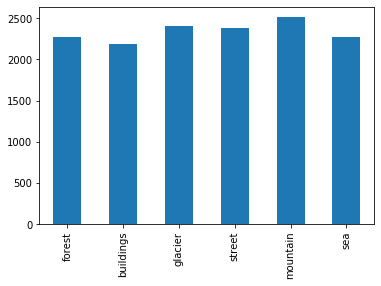

In [27]:
# Let's visualize this imbalance
import matplotlib.pyplot as plt
label_counts_df.loc['composite'].plot(kind = 'bar')

# AWS has already trained and tested the model on the test set. 
# It's performance results are on the web and don't seem to be easily downloadable. I will try to recreate them here

In [35]:
# First, get the list of files that went into the test set
# Maybe we can find the information in the Manifest Summary

import json

with open('manifest_summary.json') as f:
    data = json.load(f)
print(data)

{'errors': [], 'statistics': {'training': {'use_case': 'IMAGE_LEVEL_LABELS', 'total_json_lines': 11224, 'valid_json_lines': 11224, 'invalid_json_lines': 0, 'ignored_json_lines': 0, 'errors': [], 'error_json_line_indices': []}, 'testing': {'use_case': 'IMAGE_LEVEL_LABELS', 'total_json_lines': 2810, 'valid_json_lines': 2810, 'invalid_json_lines': 0, 'ignored_json_lines': 0, 'errors': [], 'error_json_line_indices': []}}}


In [72]:
# Not very helpful, how about the other files?

#with open('training_manifest_with_validation.json') as f:
#    data = json.load(f)
test = []  # will store a list of tuples of form (filename, class-name) in the testset.
for line in open('testing_manifest_with_validation.json'):
    temp = json.loads(line)
    test.append((temp['source-ref'].split('/')[-1], temp['auto-label-metadata']['class-name']))
    
len(test)

2810

In [146]:
# This number of files checks out for the size of the test set used by AWS
# Let's now run the model on the trained set and store the data in a DataFrame 

import boto3
client = boto3.client('rekognition', 'us-west-2', aws_access_key_id = '',\
                      aws_secret_access_key = '')

bucketName = 'intelimages2'
#bucket_name (no CAmelCase)
projectVersionArn = 'arn:aws:rekognition:us-west-2:031279063538:project/IntelImageClassifier/version/IntelImageClassifier.2020-11-18T13.17.07/1605730627545'
# Below is commented because this command need not be run repeatedly
#client.start_project_version(
#    ProjectVersionArn = projectVersionArn,
#    MinInferenceUnits = 1
#)
actual_labels = []
pred_labels = []
confidences = []

empty_pred_images = []
for image, label in test:
    response = client.detect_custom_labels(
        ProjectVersionArn = projectVersionArn,
        Image = {
                'S3Object': {'Bucket': bucketName, 'Name': 'seg_train/' + label + '/' + image}
        },
        MaxResults = 1
    )
#    if (len(response['CustomLabels']) > 1):
#        print(response['CustomLabels'])
    # I tested the above and it didn't happen. There must be more info, right? I think they are passing
    # the highest confidence level iff it's higher than the 'assumed threshold' and thus a positive
    # detection, otherwise the response['CustomLabels'] is an empty list
    if (response['CustomLabels']):  # Empty list not encountered
        actual_labels.append(label)
        pred_labels.append(response['CustomLabels'][0]['Name'])
        confidences.append(response['CustomLabels'][0]['Confidence'])
    else: # It turns out, this method gives empty predictions for some images
          # I guess we will leave these out of the analysis, though I have 
          # checked that AWS did generate prediction data for these
        empty_pred_images.append((image, label))

#results_df = pd.DataFrame({'actual label': actual_labels, 'predicted label': pred_labels, 'confidence': confidences}, \
#                         index = test)
results_df = pd.DataFrame({'actual label': actual_labels, 'predicted label': pred_labels, 'confidence': confidences})
results_df.head()


,actual label,predicted label,confidence
0,buildings,buildings,99.840996
1,buildings,buildings,99.092003
2,buildings,buildings,99.227997
3,buildings,buildings,99.925003
4,buildings,buildings,99.949997


In [147]:
# Stop the model, we have all the info we need
client.stop_project_version(ProjectVersionArn = projectVersionArn)

{'Status': 'STOPPING',
 'ResponseMetadata': {'RequestId': '7b058b9b-81ba-42f4-84b9-e6e67e88c44e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 20 Nov 2020 02:35:16 GMT',
   'x-amzn-requestid': '7b058b9b-81ba-42f4-84b9-e6e67e88c44e',
   'content-length': '21',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:
# Now I want to recreate the performance statistics found by AWS
# Or, at least get something similar (since some of the images didn't yield responses)

# But how do I know what the 'assumed threshold's are fore the different classes?
# AWS says its based on the test set which makes it seem like a calculated value.
# Based on what, minimizing the number of False Positives across all classes?
# Hmm... I think I have an idea

## Precision vs. Recall (What's the Difference??)

In [100]:
# Precision is #TP / (#TP + #FP)
# Recall is fraction of test set lables that were predicted correctly (#TP / (#TP + #FP + #FN)?
# Or is it just the fraction of records where the predicted and actual labels match
# Perhaps the images that didn't return a prediction didn't do so
# because their confidence was below the assumed threshold and thus not 'positive' detections
# In this case, they only go into the denominators for the recall calculation.
# Let's go with this interpretation for now

# Let's calculate recall first, that should be easier
num_pred_correctly = len(results_df[results_df['actual label'] == results_df['predicted label']])
print('Avg Recall = ', num_pred_correctly / 2781)

Avg Recall =  0.9510967277957569


In [108]:
# AWS calculated 0.950 for this of these. The difference must have to do with the missing predictions.
# Looking at the results on AWS, it seems there our hypothesis was correct(ish). It seems that 
# most are False Negatives. The third image, however, (8913.jpg) says True Positive on AWS. 
# I think this is because it's confidence (0.497) was rounded up to the 'assumed threshold' for this
# label('forest') (0.5).

# I could manually add the predictions from looking up the filenames on the AWS model results
# Let's do this, and creat a sep. dataframe
actual_labels = ['buildings'] + 2 * ['forest'] + 11 * ['glacier'] + 4 * ['mountain'] + 11 * ['sea']
pred_labels = actual_labels
confidences = [0.25, 0.0, 0.497, 0.144, 0.189, 0.098, 0.399, 0.293, 0.202, 0.259, 0.355, 0.127, 0.190, \
              0.115, 0.276, 0.210, 0.134, 0.128, 0.101, 0.813, 0.526, 0.864, 0.535, 0.570, 0.710, 0.684, \
              0.555, 0.885, 0.653]
# Sea has quite a high 'assumed threshold' (0.89). The one at 88.5 shows a True Positive up there, but
# gave me no response

empty_results_df = pd.DataFrame({'actual label': actual_labels, 'predicted label': pred_labels, 'confidence': confidences})
#empty_results_df.head()

# Now let's see if the average recall has changed
comp_df = results_df.append(empty_results_df)
print('Average Recall = ', len(comp_df[comp_df['actual label'] == comp_df['predicted label']]) / 2810)

Average Recall =  0.9516014234875445


In [110]:
# Now it's even further from the expected 0.950.. hmmm
# And the precision which is #TP / (#TP + #FP)
# FPs are included in the original results_df since only
# false negatives seem to be excluded
num_tp = len(results_df[results_df['actual label'] == results_df['predicted label']])
precision = num_tp / len(results_df)
print('average precision = ', precision)

average precision =  0.9510967277957569


In [111]:
# Or if we include those two boundary cases as TP,
precision = (num_tp + 2) / len(results_df)
print('average precision = ', precision)

average precision =  0.9518158935634664


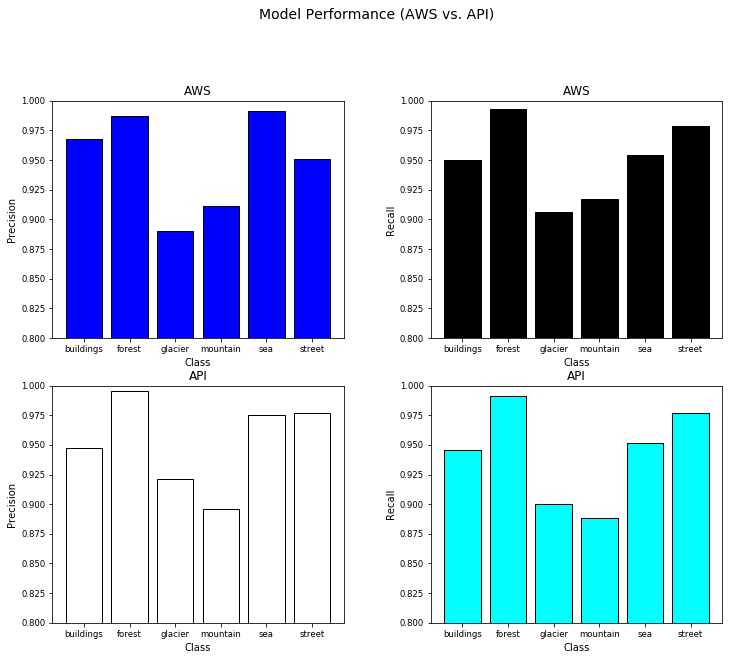

In [172]:
# These numbers are close but not quite what is given by AWS and I wonder why.
# Now let's look at precision and recall across the different classes

# Let's use the 'assumed threshold's from AWS:
thresholds = {'buildings': 0.42, 'forest': 0.50, 'glacier': 0.47, 'mountain': 0.32, \
              'sea': 0.89, 'street': 0.48}
# To compute a new column ('positive') to indicate whether or not the confidence is greater than that class's threshold
comp_df['positive'] = comp_df['confidence'] > comp_df['predicted label'].map(lambda x: thresholds[x])

precision = []
recall = []
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for label in labels:
    # Here, for precision neglect the two edge cases (count as FN)
    num_tp = len(comp_df[(comp_df['actual label'] == label) & (comp_df['predicted label'] == label) & comp_df['positive']])
    num_fp = len(comp_df[(comp_df['actual label'] == label) & (comp_df['predicted label'] != label) & comp_df['positive']])
    num_fn = len(comp_df[(comp_df['actual label'] == label) & (comp_df['predicted label'] != label)]) \
           + len(comp_df[(comp_df['actual label'] == label) & (comp_df['predicted label'] == label) & ~comp_df['positive']])
    precision.append(num_tp / (num_tp + num_fp))
    recall.append(num_tp / (num_tp + num_fn))

perf = pd.DataFrame({'precision': precision, 'recall': recall}, index = labels)

# Now manually construct perf_aws (performance measures) from the data there to compare
precision = [0.968, 0.987, 0.890, 0.911, 0.991, 0.951]
recall = [0.950, 0.993, 0.906, 0.917, 0.954, 0.979]
perf_aws = pd.DataFrame({'precision': precision, 'recall': recall}, index = labels)

fig = plt.figure(figsize = (12, 10))
title = fig.suptitle("Model Performance (AWS vs. API)", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("AWS")
ax1.set_xlabel("Class")
ax1.set_ylabel("Precision") 
ax1.set_ylim(0.8, 1.0)
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(labels, perf_aws['precision'], color='blue', 
               edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("AWS")
ax2.set_xlabel("Class")
ax2.set_ylabel("Recall") 
ax2.set_ylim(0.8, 1.0)
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(labels, perf_aws['recall'], color='black', 
               edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("API")
ax3.set_xlabel("Class")
ax3.set_ylabel("Precision") 
ax3.set_ylim(0.8, 1.0)
ax3.tick_params(axis='both', which='major', labelsize=8.5)
bar3 = ax3.bar(labels, perf['precision'], color='white', 
               edgecolor='black', linewidth=1)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("API")
ax4.set_xlabel("Class")
ax4.set_ylabel("Recall") 
ax4.set_ylim(0.8, 1.0)
ax4.tick_params(axis='both', which='major', labelsize=8.5)
bar4 = ax4.bar(labels, perf['recall'], color='cyan', 
               edgecolor='black', linewidth=1)

In [101]:
# I just learned, that for Multiclass problems, when computing the total 

[('16423.jpg', 'buildings'),
 ('10154.jpg', 'forest'),
 ('8913.jpg', 'forest'),
 ('11144.jpg', 'glacier'),
 ('12083.jpg', 'glacier'),
 ('12634.jpg', 'glacier'),
 ('14159.jpg', 'glacier'),
 ('16027.jpg', 'glacier'),
 ('2000.jpg', 'glacier'),
 ('20030.jpg', 'glacier'),
 ('4238.jpg', 'glacier'),
 ('5388.jpg', 'glacier'),
 ('6516.jpg', 'glacier'),
 ('9385.jpg', 'glacier'),
 ('1257.jpg', 'mountain'),
 ('16252.jpg', 'mountain'),
 ('17026.jpg', 'mountain'),
 ('1799.jpg', 'mountain'),
 ('10080.jpg', 'sea'),
 ('10556.jpg', 'sea'),
 ('11039.jpg', 'sea'),
 ('13479.jpg', 'sea'),
 ('14048.jpg', 'sea'),
 ('18590.jpg', 'sea'),
 ('5127.jpg', 'sea'),
 ('569.jpg', 'sea'),
 ('9057.jpg', 'sea'),
 ('9093.jpg', 'sea'),
 ('912.jpg', 'sea')]